# Tutorial for ridge regression model

Demo code for how to use the linear encoding model used in the study 
‘Single-trial neural dynamics are dominated by richly varied movements’ 
by Musall, Kaufman et al., 2019. 

This code shows how to build a design matrix based on task and movement
events, runs the linear model, shows how to analyze the fitted beta weight
and quantify cross-validated explained variance

Adapted to Python by Michael Sokoletsky, 2021


In [3]:
# Get some data from example recording
        
from ridgemodel import *

localdisk = 'D:\CompressedWidefield\A28' # path to recording

r_stack = load_stack(localdisk) # load image stock

opts_fname = pjoin(localdisk,'opts.json')
with open(opts_fname, 'r') as opts_f:
    opts = json.load(opts_f) # load some options
    
trial_onsets = np.load(pjoin(localdisk,'trial_onsets.npy'))['iframe'] # load trial onsets
trial_onsets = np.append(trial_onsets, len(r_stack)) # append last frame

In [4]:
# Get the events
events_f = np.load(pjoin(localdisk,'events.npy'), allow_pickle=True)
event_frames = events_f['iframes'] 
event_types = events_f['type']
event_labels = events_f['label']

# Make design matrix
full_R, event_idx = make_design_matrix(event_frames, event_types, trial_onsets, opts) # make design matrix for events


Building design matrix: 100%|████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 40.91it/s]


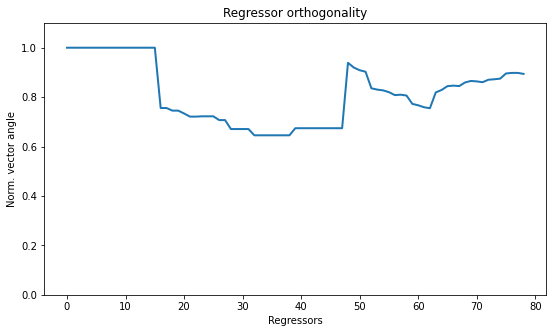

In [5]:
# Run QR and check for rank-defficiency. This will show whether a given regressor is highly collinear with other regressors in the design matrix.

"""
This section plots regressor orthogonality. The resulting plot ranges from 0 to 1 for each regressor, with 1 being
fully orthogonal to all preceeding regressors in the matrix and 0 being
fully redundant. Having fully redundant regressors in the matrix will
break the model, so those regressors are removed. In
practice, you should understand where the redundancy is coming from and
change your model design to avoid it in the first place!
"""

%matplotlib inline 

full_QRR, full_R, event_idx = calc_regressor_orthogonality(full_R, event_idx, rmv = True) # orthogonalize normalized design matrix and remove redundant regressors

plot_regressor_orthogonality(full_QRR) # show how orthogonal individual regressors are to the rest of the matrix

np.savez(pjoin(localdisk, 'design'), full_R=full_R, event_idx=event_idx, event_labels=event_labels, event_types = event_types, full_QRR=full_QRR) # save design matrix and event labels


In [6]:
# Run cross-validation

# full model - this will take a moment
[full_m_stack, full_beta, _, full_idx, full_ridge, full_labels] = cross_val_model(full_R, r_stack, event_labels, event_idx, event_labels, opts['n_folds'])
full_cvR2 = model_corr(r_stack, full_m_stack)[0] ** 2 # compare the real and model stacks

np.savez(pjoin(localdisk, 'full_m'), U=full_m_stack.U, SVT=full_m_stack.SVT, beta=full_beta, R=full_R, idx=full_idx, ridge=full_ridge, labels=full_labels, cvR2 = full_cvR2) # save the results

Performing cross-validation: 100%|█████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.15s/it]
C:\Users\michaeso.WISMAIN\Anaconda3\lib\site-packages\ridgemodel-0.1-py3.8.egg\ridgemodel\utils.py:130: RuntimeWarning: invalid value encountered in true_divide
  corr_mat = (cov_P / std_Px_Py).T


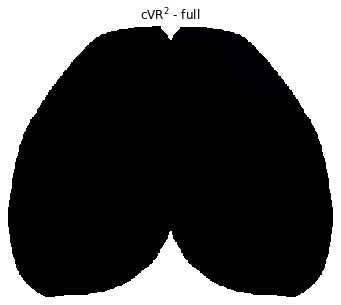

In [7]:
# Show R^2 results

%matplotlib inline

plot_model_corr(full_cvR2, 'full')